In [12]:
import torch
import torch.nn as nn #neural networks
import torch.optim as optim

from torchvision import utils
from torchvision import datasets
from torchvision import transforms

from PIL import Image
import urllib.request as request
from matplotlib import pyplot as plt

# Construyendo un modelo

In [13]:
data_path = 'data/'

full_data_set = datasets.CIFAR10(data_path, train=True, download=True,
                                 transform = transforms.Compose(
                                    [transforms.ToTensor(),
                                    transforms.Normalize((0.4915, 0.4823, 0.4468), 
                                                         (0.2470, 0.2435, 0.2616))
                                  ]))





full_validation_set = datasets.CIFAR10(data_path, train=False, download=True, 
                                  transform = transforms.Compose(
                                  [transforms.ToTensor(),
                                  transforms.Normalize((0.4915, 0.4823, 0.4468), 
                                                       (0.2470, 0.2435, 0.2616))
                                ]))

Files already downloaded and verified
Files already downloaded and verified


In [14]:
# Vamos a usar un dataloader para cargar los datos en un tamaño de batch especifico
size = 4
dataloader = torch.utils.data.DataLoader(full_data_set, batch_size=size, shuffle = True, num_workers=2)

In [15]:
len(full_data_set)

50000

In [16]:
len(full_validation_set)

10000

Vamos a crear un iterador sobre  el data loader para obtener las imagenes y las etiquetas

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat
truck
horse
ship


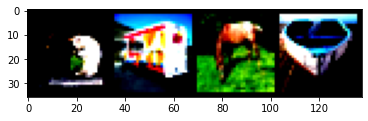

In [17]:
data_iterator = iter(dataloader)
imgs, labels = data_iterator.next()

classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

plt.imshow(utils.make_grid(imgs).permute(1, 2,0))

for i in range(size):
  print(classes[labels[i]])

De todo este dataset nos vamos a quedar unicamente con dos clases: car (posicion 1) y cat (posicion 3), y vamos a crear un nuevo dataset 

In [18]:
class_names = ['car', 'cat']

label_map = {1: 0, 3: 1}

data_set = [(img, label_map[label]) for img, label in full_data_set if label in [1,3]]
validation_set = [(img, label_map[label]) for img, label in full_validation_set if label in [1,3]]

In [19]:
img, label = data_set[20]
img.shape

torch.Size([3, 32, 32])

Vamos a crear un modelo basado en una transformacion lineal de 32 x 32 x 3, ya que estamos intentando realizar una red neuronal, debemos utilizar una funcion de activacion, arbitrariamente usaremos una tangente hiperbolica **tanH**, pero haremos varias pruebas para ver que nos funciona mejor, luego de tanH vamos a tener una salida que necesitamos sea un resultado de un clasificador binario.

In [20]:
model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512), 
    # dimension imagenes, numero de nodos de salidas de neuronas
    nn.Tanh(),
    nn.Linear(512, 2)
)

El resultado final debe ser una probabilidad, por lo que puedo trabajar con el sigmoide o con softmax (vemos ejemplo)

In [21]:
def softmax(x):
  return torch.exp(x) / torch.exp(x).sum()

In [22]:
x = torch.tensor([1.0, 2.0, 3.0])

In [25]:
softmax(x).sum()
# La suma de cada evaluacion nos da 1

tensor(1.)

Agregamos al modelo la funcion softmax de pytorch

In [39]:
model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512), 
    # dimension imagenes, numero de nodos de salidas de neuronas
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1) # Usamos mas de una variable
)

Aplicamos el modelo a la imagen 20 del dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


this image is a car


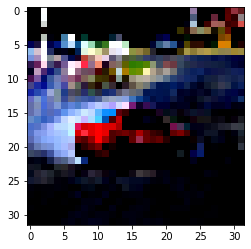

In [44]:
img, label = data_set[20]
plt.imshow(img.permute(1, 2, 0))
print(f'this image is a {class_names[label]}')

In [41]:
out =model(img.view(-1).unsqueeze(0))
out

tensor([[0.5432, 0.4568]], grad_fn=<SoftmaxBackward>)

Obtenemos la posicion del indice con torch.max() en el dataset para la prediccion

In [57]:
_, index = torch.max(out, dim=1) 
print('train dataset:', class_names[label], '| model:', class_names[index])

train dataset: car | model: car


# Implementando un clasificador totalmente conectado




En esta seccion vamos a cambiar Softmax por una funcion logaritmica dadas sus limitantes

In [58]:
model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512), 
    # dimension imagenes, numero de nodos de salidas de neuronas
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1) # Usamos mas de una variable
)

loss_function = nn.NLLLoss()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


this image is a car


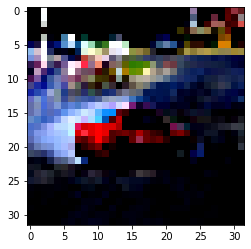

In [62]:
img, label = data_set[20]
plt.imshow(img.permute(1, 2, 0))
print(f'this image is a {class_names[label]}')

In [63]:
out = model(img.view(-1).unsqueeze(0))
print(out)

print('train dataset:', class_names[label], '| model:', class_names[index])

tensor([[0.5432, 0.4568]], grad_fn=<SoftmaxBackward>)
train dataset: car | model: car


Creamos un loop de entrenamiento

In [68]:
model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512), 
    # dimension imagenes, numero de nodos de salidas de neuronas
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1) # Usamos mas de una variable
)

loss_function = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

n_epochs = 5 #iteraciones

for epoch in range(n_epochs):
  for img, label in data_set:
    out = model(img.view(-1).unsqueeze(0))
    loss = loss_function(out, torch.tensor([label]))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Eoch: {epoch}, Loss: {float(loss)}")

Eoch: 0, Loss: 0.004508924670517445
Eoch: 1, Loss: 0.00025507534155622125
Eoch: 2, Loss: 0.0016753936652094126
Eoch: 3, Loss: 0.20855467021465302
Eoch: 4, Loss: 0.025889664888381958


In [69]:
# Haciendo uno del train_loader
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512), 
    # dimension imagenes, numero de nodos de salidas de neuronas
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1) # Usamos mas de una variable
)

loss_function = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

n_epochs = 100 #iteraciones

for epoch in range(n_epochs):
  for img, label in train_loader:
    out = model(img.view(img.shape[0], -1))
    loss = loss_function(out, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Eoch: {epoch}, Loss: {float(loss)}")

Eoch: 0, Loss: 0.49279510974884033
Eoch: 1, Loss: 0.4627804160118103
Eoch: 2, Loss: 0.40452173352241516
Eoch: 3, Loss: 0.5009709000587463
Eoch: 4, Loss: 0.40688228607177734
Eoch: 5, Loss: 0.16663683950901031
Eoch: 6, Loss: 0.736009955406189
Eoch: 7, Loss: 0.24405360221862793
Eoch: 8, Loss: 0.4584231972694397
Eoch: 9, Loss: 0.3229501247406006
Eoch: 10, Loss: 0.33314457535743713
Eoch: 11, Loss: 0.4533260762691498
Eoch: 12, Loss: 0.15020345151424408
Eoch: 13, Loss: 0.22035002708435059
Eoch: 14, Loss: 0.30067941546440125
Eoch: 15, Loss: 0.16609427332878113
Eoch: 16, Loss: 0.24653933942317963
Eoch: 17, Loss: 0.1377934217453003
Eoch: 18, Loss: 0.10984954982995987
Eoch: 19, Loss: 0.24569493532180786
Eoch: 20, Loss: 0.30841052532196045
Eoch: 21, Loss: 0.23673951625823975
Eoch: 22, Loss: 0.10636528581380844
Eoch: 23, Loss: 0.10353677719831467
Eoch: 24, Loss: 0.22059175372123718
Eoch: 25, Loss: 0.09661704301834106
Eoch: 26, Loss: 0.10115322470664978
Eoch: 27, Loss: 0.041176408529281616
Eoch: 28,

In [74]:
# Validamos el loss
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]

        correct += int((predicted == labels).sum())

print("Accuracy: %f"% (correct / total))     

Accuracy: 0.874500


In [79]:
img, label = validation_set[20]
out = model(img.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
out

tensor([[-5.7220e-06, -1.2072e+01]], grad_fn=<LogSoftmaxBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->:  car  model: car


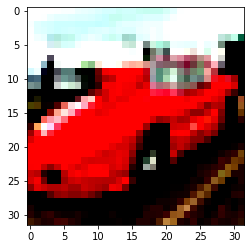

In [80]:
print('->: ',class_names[label],' model:',class_names[index])
plt.imshow(img.permute(1, 2, 0))
plt.show()

# Mejoras, limitaciones y conclusiones

In [81]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 1024), #3072 = 3*32*32 
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512,128),
    nn.Tanh(),
    nn.Linear(128,2),

)

#LogSoftmax tiene un efecto CrossEntropyLoss
loss_function = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

n_epochs = 100 #iteraciones

for epoch in range(n_epochs):
  for img, label in train_loader:
    out = model(img.view(img.shape[0], -1))
    loss = loss_function(out, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Eoch: {epoch}, Loss: {float(loss)}")

Eoch: 0, Loss: 0.5255762934684753
Eoch: 1, Loss: 0.4492831826210022
Eoch: 2, Loss: 0.4254150688648224
Eoch: 3, Loss: 0.39274781942367554
Eoch: 4, Loss: 0.21855056285858154
Eoch: 5, Loss: 0.43661069869995117
Eoch: 6, Loss: 0.20315231382846832
Eoch: 7, Loss: 0.311131089925766
Eoch: 8, Loss: 0.1332254260778427
Eoch: 9, Loss: 0.2911366820335388
Eoch: 10, Loss: 0.23524853587150574
Eoch: 11, Loss: 0.3612228035926819
Eoch: 12, Loss: 0.1773201823234558
Eoch: 13, Loss: 0.3424760401248932
Eoch: 14, Loss: 0.2973201274871826
Eoch: 15, Loss: 0.19631099700927734
Eoch: 16, Loss: 0.15087349712848663
Eoch: 17, Loss: 0.23383039236068726
Eoch: 18, Loss: 0.023667041212320328
Eoch: 19, Loss: 0.055586617439985275
Eoch: 20, Loss: 0.11876586079597473
Eoch: 21, Loss: 0.11808904260396957
Eoch: 22, Loss: 0.29596585035324097
Eoch: 23, Loss: 0.2815849184989929
Eoch: 24, Loss: 0.1852562576532364
Eoch: 25, Loss: 0.09997506439685822
Eoch: 26, Loss: 0.3450622856616974
Eoch: 27, Loss: 0.08764726668596268
Eoch: 28, Loss

In [82]:
# Validamos el loss
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]

        correct += int((predicted == labels).sum())

print("Accuracy: %f"% (correct / total)) 

Accuracy: 1.000000


Nos encontramos con un modelo con overfiting sobre entrenado

In [83]:
### realizamos una suma de parametros (pesos)
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

El numero de parametros es muy grande para un dataset tan pequeño


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


correct: car   model: cat


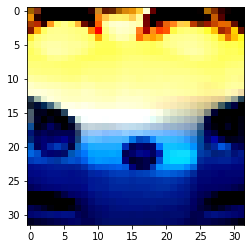

In [84]:
image = request.urlretrieve('https://i.pinimg.com/originals/43/bc/47/43bc47066bb8b2fa4fe7cc8e82cc3714.jpg','test,jpg')
                            
img = Image.open(image[0])

preprocess = transforms.Compose([
        transforms.Resize(48),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4915, 0.4823, 0.4468],
            std=[0.2470, 0.2435, 0.2616]
        )])

img_t = preprocess(img)
out = model(img_t.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
print('correct: car ',' model:',class_names[index])
plt.imshow(img_t.permute(1, 2, 0))

Subir un grado de mejora seria trabajar con convulucion